## Grader scores

In [1]:
import os
import csv
import numpy as np

from sklearn import metrics
from matplotlib import pylab as plt
import pandas as pd
from collections import Counter


In [2]:
def se_sp(ref, obs):
    tp = np.sum((ref == 1) & (obs == 1))
    tn = np.sum((ref == 0) & (obs == 0))
    fp = np.sum((ref == 0) & (obs == 1))
    fn = np.sum((ref == 1) & (obs == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity, tp, tn, fp, fn

## Load graders scores

In [3]:
grader_folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/'

#Himanshu Patel - Consultant
#Anne-Marie Hinds - Consultant
#Rob Henderson - Consultant
#Meena Arun - Fellow
#Janette Ravello - Nurse specialist

all_gradings = {}
for grader in 'HP', 'AMH', 'MA', 'RH':
    for grading in 'Normal', 'Plus', 'Pre-Plus':
        folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/{}'.format(grader, grading)
        if grader == 'RH':
            folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/ROP AI project/{}'.format(grader, grading)
        for filename in os.listdir(folder):
            if not filename.endswith('.png'):
                 continue
            all_gradings[grader, filename] = grading.lower()
            
df = pd.read_excel('/media/QNAP/People/BartLiefers/ROP/Independent Test/JR/Copy of Ravelo_ROP.xlsx', engine='openpyxl')
for i, row in df.iterrows():
    all_gradings['JR', row.File] = row.Diagnosis.lower()
    
len(all_gradings)

/usr/local/lib/python3.6/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


1000

In [4]:
# these are the files graded by all
test_filenames = list(set(filename for grader, filename in all_gradings))
len(test_filenames)

200

## Other graders plus reference 

In [5]:
#data_folder = '/media/QNAP/People/GongyuZhang/ROP/data/raw/image/'
with open('../src/data/data_split.csv', 'r') as f:
    content = list(csv.reader(f))
    grading_header = content[0]
    grading_data = content[1:]
    
for row in grading_data:
    for grader, grading in zip(grading_header[2:], row[2:]):
        filename = row[0]
        if filename in test_filenames:
            all_gradings[grader, filename] = grading


In [6]:
# exclude GA and group
all_graders = 'AMH', 'CH', 'GA', 'JR', 'JT', 'HP', 'KP', 'MA', 'RH', 'SB'
class_names = 'normal', 'pre-plus', 'plus'

In [7]:
graders_full_set = {g for g in all_graders if all(all_gradings[g, f] in class_names for f in test_filenames)}

## Majority

In [8]:
for fn in test_filenames:
    counts = Counter([all_gradings[grader, fn] for grader in graders_full_set])
    majority, _ = counts.most_common(1)[0]
    all_gradings['majority', fn] = majority

## Load model output

In [9]:
with open('model_classification_all_files.csv', 'r') as f:
    content = list(csv.reader(f))
    model_header = content[0]
    model_data = content[1:]

model_gradings = {}    
for file, model, normal, pre_plus, plus in model_data:
    model_gradings[file, int(model), 'normal'] = float(normal)
    model_gradings[file, int(model), 'pre-plus'] = float(pre_plus)
    model_gradings[file, int(model), 'plus'] = float(plus)
    
# average for each class
for file in test_filenames:
    for class_name in class_names:
        model_gradings[file, class_name] = sum(model_gradings[file, i, class_name] for i in range(5)) / 5
'''        
ensemble_list = [np.mean([1 - model_gradings[filename, i, 'normal'] for i in range(5)])
    for filename in test_filenames]

ensemble_index = {filename: grading for filename, grading in zip(test_filenames, ensemble_list)}

plt.hist(ensemble_index.values())
plt.show()
'''
pass

## Calibrate
TODO: on validation set

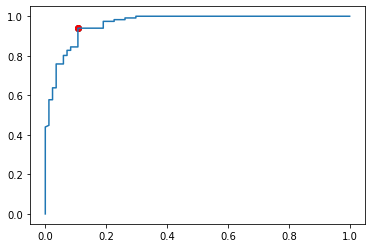

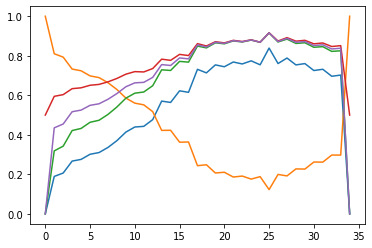

In [10]:
reference_grader = 'HP'
class_name = 'normal'

x = [all_gradings[reference_grader, filename] == class_name for filename in test_filenames]
y = [model_gradings[filename, class_name] for filename in test_filenames]
fpr, tpr, threshold = metrics.roc_curve(x, y)
plt.plot(fpr, tpr)

product = [(1 - fp) * tp for fp, tp in zip(fpr, tpr)]
i = np.argmax(product)
plt.scatter(fpr[i], tpr[i], c='k')

dist_to_corner = [np.sqrt(fp**2 + (1-tp)**2)
                  for fp, tp in zip(fpr, tpr)]
i = np.argmin(dist_to_corner)
plt.scatter(fpr[i], tpr[i], c='r')

harmonic_mean = [(2 * (1-fp)*tp) / ((1-fp) + tp)
                  for fp, tp in zip(fpr, tpr)]

arithmetic_mean = [((1-fp) + tp) / 2
                  for fp, tp in zip(fpr, tpr)]

geometric_mean = [np.sqrt((1-fp)*tp)
                  for fp, tp in zip(fpr, tpr)]

plt.show()
plt.plot(product)
plt.plot(dist_to_corner)
plt.plot(harmonic_mean)
plt.plot(arithmetic_mean)
plt.plot(geometric_mean)

In [11]:
def get_threshold(class_name, reference_grader):
    x = [all_gradings[reference_grader, filename] == class_name for filename in test_filenames]
    y = [model_gradings[filename, class_name] for filename in test_filenames]

    fpr, tpr, threshold = metrics.roc_curve(x, y)
    dist_to_corner = [np.sqrt(fp**2 + (1-tp)**2)
                      for fp, tp in zip(fpr, tpr)]
    i = np.argmin(dist_to_corner)
    return threshold[i]

In [12]:
calibrated_scores = {}
exponent = {}

def set_calibrated_scores(reference):
    for class_name in class_names:
        exponent[class_name] = - np.log(2) / np.log(get_threshold(class_name, reference))

    for file in test_filenames:
        calibrated = [model_gradings[file, class_name]**exponent[class_name] for class_name in class_names]
        calibrated_scores[file] = calibrated
        all_gradings['calibrated', file] = class_names[np.argmax(calibrated)]

In [13]:
set_calibrated_scores('HP')

for file in test_filenames:
    print(file)
    print(all_gradings['majority', file])
    print('original  ', '{:.3f} {:.3f} {:.3f}'.format(* [model_gradings[file, class_name] for class_name in class_names]))
    print('calibrated', '{:.3f} {:.3f} {:.3f}'.format(* [model_gradings[file, class_name]**exponent[class_name] for class_name in class_names]))
    print()
    

2508cb6b-5042-429d-84ae-b7b96d320370.2.png
plus
original   0.796 0.000 0.204
calibrated 0.000 0.535 0.315

9f421e90-c634-4fc6-8eca-909a825f5908.10.png
pre-plus
original   0.000 0.000 1.000
calibrated 0.000 0.431 1.000

bb0d6a65-0afa-4fab-a872-48cc1398f6d8.44.png
pre-plus
original   0.207 0.000 0.793
calibrated 0.000 0.539 0.845

d0d55d12-e439-4c4e-bffe-f4ba22a1268a.47.png
pre-plus
original   0.941 0.000 0.059
calibrated 0.035 0.596 0.128

03255041-b3a3-4fc2-b449-b4cae007716e.2.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.379 0.000

4c774f0e-7e4c-4d73-86cf-29893fffa4c4.11.png
pre-plus
original   0.191 0.000 0.809
calibrated 0.000 0.564 0.857

ec129719-ba23-4d4b-a083-bd341620f28e.12.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.407 0.000

ef86cb75-7c27-4783-99e3-ff8fee0bf1eb.1.png
plus
original   0.001 0.000 0.999
calibrated 0.000 0.538 0.999

49e45b28-9afd-4188-bb33-4dcb87e8d2d4.17.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.400 0.000

be0843f9-

In [19]:
def print_confusion(reference, observer):
    print('{:>40s}'.format(observer))
    print('{:>18s} {:>8s} {:>8s} {:>8s}'.format('', *class_names))
    for x_class_name in class_names:
        if x_class_name == 'pre-plus':
            print('{:>18s}'.format(reference + '  ' + x_class_name), end=' ')
        else:
            print('{:>18s}'.format(x_class_name), end=' ')
            
        ref = np.array([all_gradings[reference, file] == x_class_name for file in test_filenames])
        for y_class_name in class_names:
            obs = np.array([all_gradings[observer, file] == y_class_name for file in test_filenames])
            print('{:8d}'.format(np.count_nonzero(ref & obs)), end=' ')
        print()
        
    print()
    print('referability (normal vs plus/pre-plus)')
    r = np.array([all_gradings[reference, file] != 'normal' for file in test_filenames])
    o = np.array([all_gradings[observer, file] != 'normal' for file in test_filenames])
    sensitivity, specificity, tp, tn, fp, fn = se_sp(r, o)
    print('sensitivity: {:.3f}'.format(sensitivity))
    print('specificity: {:.3f}'.format(specificity))

In [20]:
print_confusion('GA', 'calibrated')

                              calibrated
                     normal pre-plus     plus
            normal      115       15       13 
      GA  pre-plus        2       11        5 
              plus        0        8       31 

referability (normal vs plus/pre-plus)
sensitivity: 0.965
specificity: 0.804


In [21]:
print_confusion('HP', 'calibrated')

                              calibrated
                     normal pre-plus     plus
            normal      108        8        0 
      HP  pre-plus        9       20       17 
              plus        0        6       32 

referability (normal vs plus/pre-plus)
sensitivity: 0.893
specificity: 0.931


In [22]:
print_confusion('majority', 'calibrated')

                              calibrated
                     normal pre-plus     plus
            normal      108        5        0 
majority  pre-plus        9       24       18 
              plus        0        5       31 

referability (normal vs plus/pre-plus)
sensitivity: 0.897
specificity: 0.956


In [23]:
print_confusion('majority', 'GA')

                                      GA
                     normal pre-plus     plus
            normal      111        2        0 
majority  pre-plus       22       15       14 
              plus       10        1       25 

referability (normal vs plus/pre-plus)
sensitivity: 0.632
specificity: 0.982


Compared to majority vote, GA classified 22 pre-plus and 10 plus cases as normal

## Observer scores

In [25]:
def get_se_sp(reference, observer, filenames):
    # only evaluate files with valid grading
    include_filenames = [fn for fn in filenames if all_gradings[observer, fn] in class_names]

    # normal -> 0, plus/pre-plus -> 1
    ref = np.array([int(all_gradings[reference, fn] != 'normal') for fn in include_filenames])
    obs = np.array([int(all_gradings[observer, fn] != 'normal') for fn in include_filenames])
   
    return se_sp(ref, obs) 

def print_table(reference):
    print('{:15s} {:>8s} {:>8s} {:>4s} {:>4s} {:>4s} {:>4s} {:>4s}'.format('observer', 'SE', 'SP', 'TP', 'TN', 'FP', 'FN', 'N'))

    for observer in all_graders:
        if observer == reference:
             continue
        sensitivity, specificity, tp, tn, fp, fn = get_se_sp(reference, observer, test_filenames)
        print('{:15s} {:>8.3f} {:>8.3f} {:>4d} {:>4d} {:>4d} {:>4d} {:>4d}'.format(observer, sensitivity, specificity, tp, tn, fp, fn, sum([tp, tn, fp, fn])))
    

In [26]:
# compare other graders to HP
print_table('HP')

observer              SE       SP   TP   TN   FP   FN    N
AMH                0.952    0.931   80  108    8    4  200
CH                 0.974    0.920   37   46    4    1   88
GA                 0.631    0.966   53  112    4   31  200
JR                 0.905    0.922   76  107    9    8  200
JT                 0.974    0.934   37   57    4    1   99
KP                 0.979    0.510   46   26   25    1   98
MA                 0.952    0.922   80  107    9    4  200
RH                 1.000    0.853   84   99   17    0  200
SB                 0.979    0.768   46   43   13    1  103


In [27]:
# compare other graders to GA
print_table('GA')

observer              SE       SP   TP   TN   FP   FN    N
AMH                0.965    0.769   55  110   33    2  200
CH                 0.938    0.804   30   45   11    2   88
JR                 0.947    0.783   54  112   31    3  200
JT                 0.969    0.851   31   57   10    1   99
HP                 0.930    0.783   53  112   31    4  200
KP                 1.000    0.370   25   27   46    0   98
MA                 0.965    0.762   55  109   34    2  200
RH                 1.000    0.692   57   99   44    0  200
SB                 0.960    0.551   24   43   35    1  103


In [28]:
# compare other graders to majority
print_table('majority')

observer              SE       SP   TP   TN   FP   FN    N
AMH                1.000    0.991   87  112    1    0  200
CH                 0.927    0.936   38   44    3    3   88
GA                 0.632    0.982   55  111    2   32  200
JR                 0.885    0.929   77  105    8   10  200
JT                 0.976    0.983   40   57    1    1   99
HP                 0.920    0.965   80  109    4    7  200
KP                 1.000    0.529   47   27   24    0   98
MA                 1.000    0.982   87  111    2    0  200
RH                 0.989    0.867   86   98   15    1  200
SB                 1.000    0.786   47   44   12    0  103


## Bootstrap ROC

In [38]:
# interpolate false positive rates from 0 to 1 in steps of 0.01
base_fpr = np.linspace(0, 1, 101)

def get_bootstrap_fpr(reference_sample, ensemble_sample):
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)
    return np.interp(base_fpr, fpr, tpr)

def bootstrap_model(reference, class_name='normal', n_bootstraps=1000):

    set_calibrated_scores(reference)
    
    bootstrap_samples = [np.random.choice(test_filenames, size=len(test_filenames), replace=True) for _ in range(n_bootstraps)]
    
    bootstrap_ensemble_list = [[model_gradings[fn, class_name] for fn in sample] for sample in bootstrap_samples]
    bootstrap_reference_list = [[all_gradings[reference, fn]==class_name for fn in sample] for sample in bootstrap_samples]
                           
    all_fprs = [get_bootstrap_fpr(reference_sample, ensemble_sample)
                for reference_sample, ensemble_sample 
                in zip(bootstrap_reference_list, bootstrap_ensemble_list)]

    lower_fpr = np.percentile(all_fprs, 2.5, axis=0)
    upper_fpr = np.percentile(all_fprs, 97.5, axis=0)
    
    return lower_fpr, upper_fpr, bootstrap_samples

def get_error_bar(reference, observer, bootstrap_samples, ci=95):
    d = (100 - ci) / 2 # lower and upper percentiles
    
    se, sp, tp, tn, fp, fn = get_se_sp(reference, observer, test_filenames)
    se_bootstrap, sp_bootstrap, _, _, _, _ = np.array([get_se_sp(reference, observer, sample) for sample in bootstrap_samples]).T
    
    yerr = np.array([[se - np.percentile(se_bootstrap, d)], [np.percentile(se_bootstrap, 100 - d) - se]])
    xerr = np.array([[sp - np.percentile(sp_bootstrap, d)], [np.percentile(sp_bootstrap, 100 - d) - sp]])
    
    return se, sp, xerr, yerr

def plot_bootstrap_roc(reference, class_name='normal'):
    
    ensemble_sample = [model_gradings[fn, class_name] for fn in test_filenames]
    reference_sample = [all_gradings[reference, fn]==class_name for fn in test_filenames]
                       
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)

    lower_fpr, upper_fpr, bootstrap_samples = bootstrap_model(reference, class_name)

    plt.figure(figsize=(30, 10))

    for i, observer in enumerate(all_graders):
        ax = plt.subplot(2, 5, i+1)

        ax.plot(fpr, tpr, label='ensemble', c='k')
        ax.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

        se, sp, xerr, yerr = get_error_bar(reference, observer, bootstrap_samples)
        ax.errorbar(1 - sp, se, yerr=yerr, xerr=xerr, capsize=10, c='r') 

        ax.set_title(observer)
        ax.set_xlabel('1 - Specificity')
        ax.set_ylabel('Sensitivity')
        ax.set_ylim(0.5, 1.01)
        ax.set_xlim(0.0, 0.9)
    plt.show()

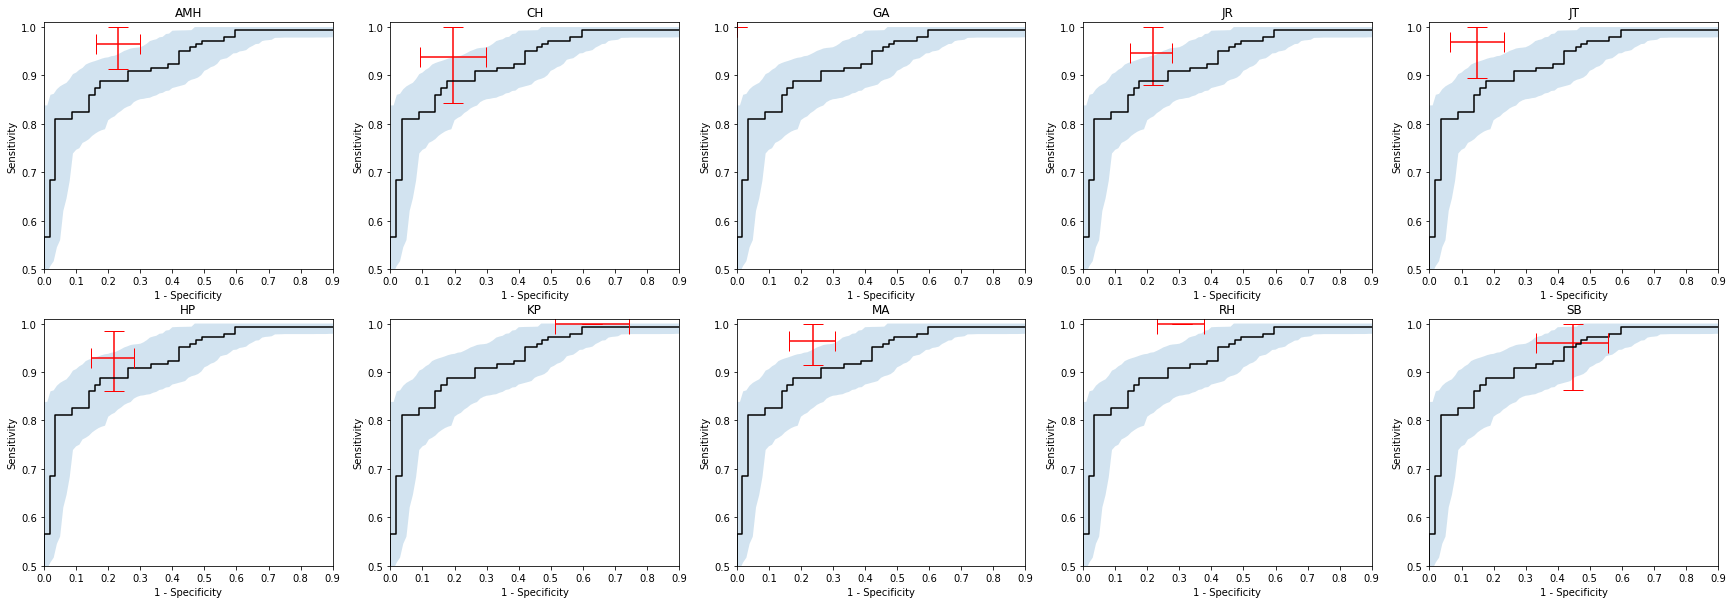

In [55]:
# Compare model and graders to GA
plot_bootstrap_roc('GA')

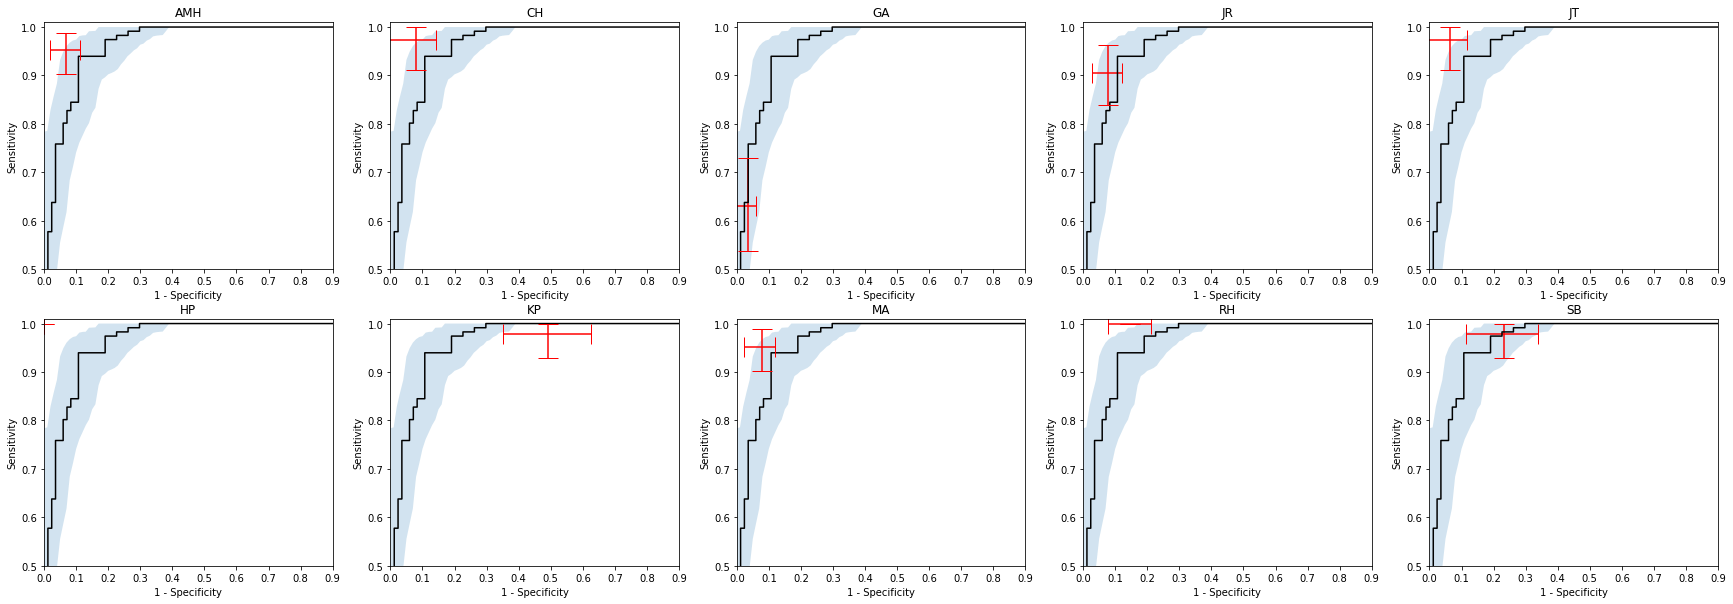

In [39]:
# Compare model and graders to HP
plot_bootstrap_roc('HP')

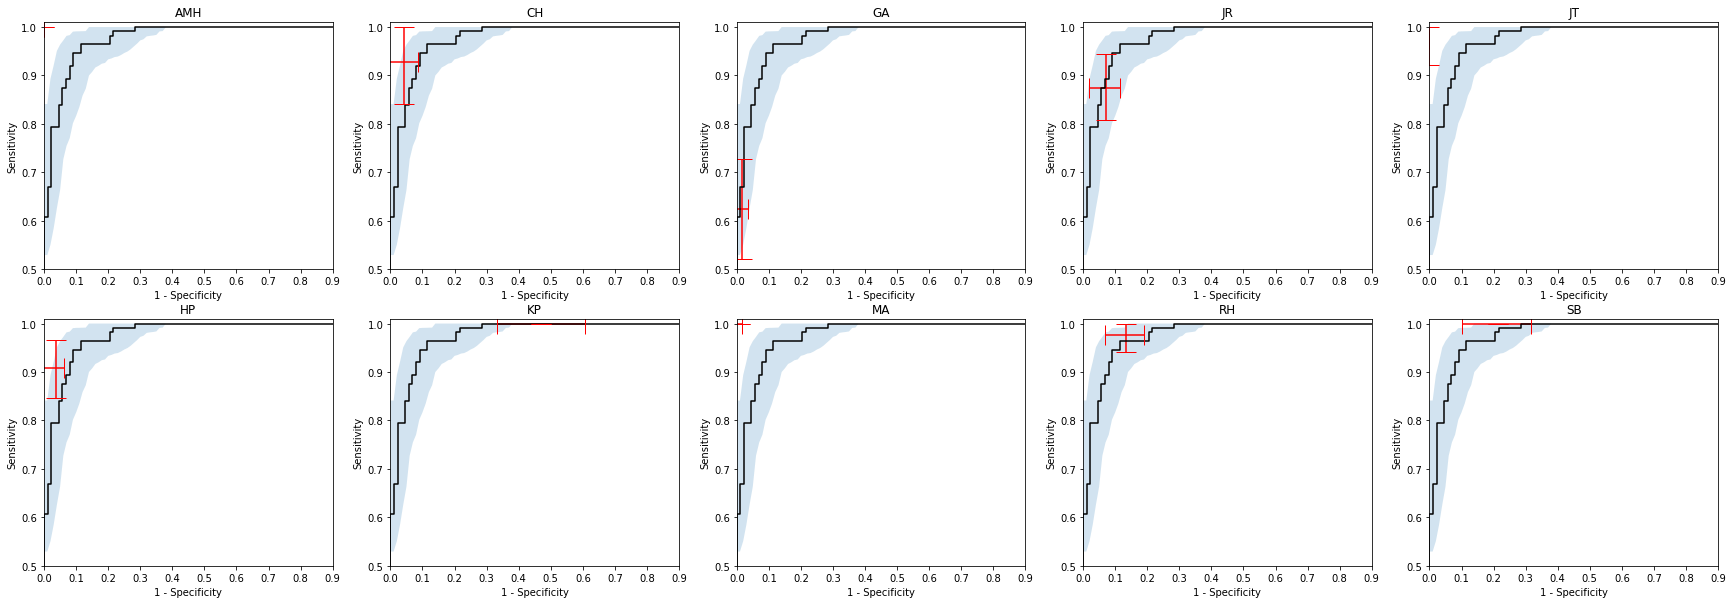

In [54]:
# Compare model and graders to AMH
plot_bootstrap_roc('AMH')

## AUC compared to different reference graders

AUC for normal is referable/non-referable

In [42]:
from sklearn.metrics import roc_auc_score
for class_name in class_names:
    print(class_name)
    print('grader   AUC')
    o = [model_gradings[fn, class_name] for fn in test_filenames]
    for grader in graders_full_set:
        r = [all_gradings[grader, fn] == class_name for fn in test_filenames]    
        print('{:8s} {:.3f}'.format(grader, roc_auc_score(r, o)))
    print()

    r = [all_gradings['majority', fn] == class_name for fn in test_filenames]
    print('{:8s} {:.3f}'.format('majority', roc_auc_score(r, o)))
    print()
    print()
    

normal
grader   AUC
MA       0.975
JR       0.952
GA       0.932
RH       0.954
AMH      0.976
HP       0.963

majority 0.976


pre-plus
grader   AUC
MA       0.817
JR       0.761
GA       0.817
RH       0.685
AMH      0.826
HP       0.782

majority 0.821


plus
grader   AUC
MA       0.921
JR       0.937
GA       0.941
RH       0.970
AMH      0.907
HP       0.941

majority 0.936




## AUC for each class

In [43]:
def print_auc(reference):

    for class_name in class_names:
        r = [all_gradings[reference, fn] == class_name for fn in test_filenames]
        o = [model_gradings[fn, class_name] for fn in test_filenames]

        print('{:8s} {:.3f}'.format(class_name, roc_auc_score(r, o)))

In [44]:
print_auc('HP')

normal   0.963
pre-plus 0.782
plus     0.941


In [45]:
print_auc('GA')

normal   0.932
pre-plus 0.817
plus     0.941


## Cases where everyone disagrees with GA:


In [46]:
ga_different_files = [fn for fn in test_filenames if all(all_gradings[grader, fn] != all_gradings['GA', fn] for grader in graders_full_set - {'GA'})]

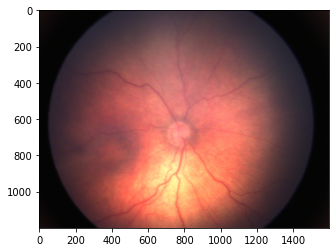

9f421e90-c634-4fc6-8eca-909a825f5908.1.png
GA:         plus
normal      []
pre-plus    ['AMH', 'CH', 'JR', 'JT', 'HP', 'MA', 'RH']
plus        ['GA']
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 0.56
------------------------------


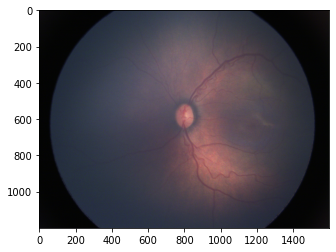

bc854dfc-559b-4c64-86ba-550d5f240178.15.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: plus                                                                                                  
calibrated: 0.00 0.59 0.61
------------------------------


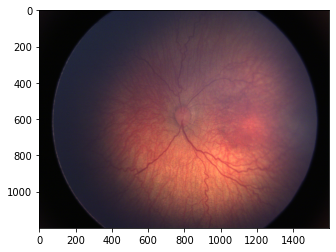

e68d2e10-d9f3-4cb2-9e3f-298b2bd101b7.14.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'RH']
plus        ['KP', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.56 0.88
------------------------------


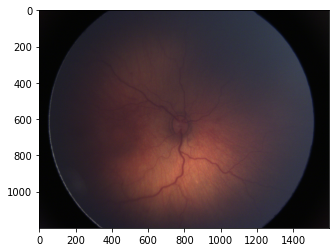

0bc6af60-5ac5-4b0b-a8a6-a92c0ff7951e.9.png
GA:         plus
normal      []
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'RH', 'SB']
plus        ['GA', 'KP']
calibrated: plus                                                                                                  
calibrated: 0.00 0.48 1.00
------------------------------


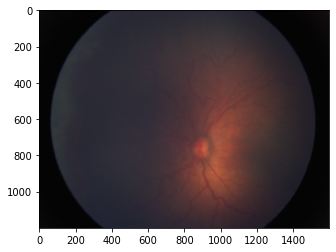

609a9add-f8b0-4451-a08a-cb4d5eb1b8cf.55.png
GA:         normal
normal      ['GA']
pre-plus    ['KP', 'SB']
plus        ['AMH', 'JR', 'HP', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.79
------------------------------


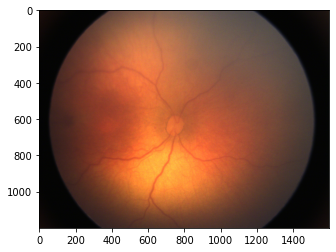

91f8a621-37ee-4518-803b-16df1a6d4f04.16.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: normal                                                                                                
calibrated: 1.00 0.44 0.01
------------------------------


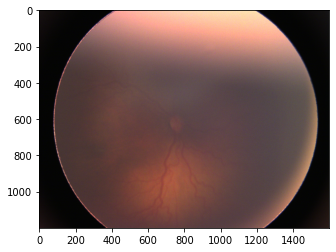

fad42744-74e4-40c2-9679-7eaa158c5de1.1.png
GA:         normal
normal      ['GA']
pre-plus    ['JR']
plus        ['AMH', 'HP', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.59 0.77
------------------------------


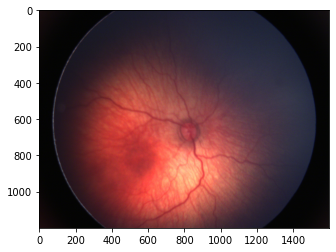

d642ce5b-8204-48a6-bffd-e4db7059dee1.4.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'RH']
plus        ['KP', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.57 0.72
------------------------------


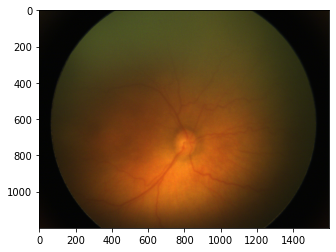

ac0699a1-ce4a-41f8-bdea-172e496cb803.2.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'RH']
plus        ['KP', 'SB']
calibrated: normal                                                                                                
calibrated: 0.98 0.46 0.03
------------------------------


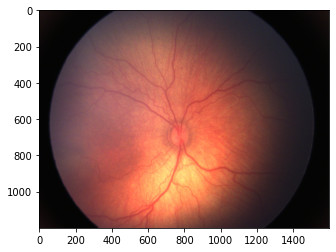

225ef7e2-8600-4da1-847f-2a5be0659bf6.11.png
GA:         normal
normal      ['GA']
pre-plus    []
plus        ['AMH', 'CH', 'JR', 'JT', 'HP', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 0.80
------------------------------


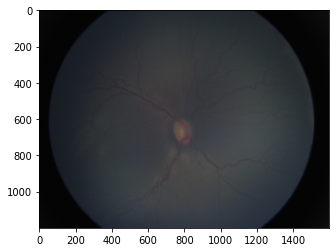

400050b4-eaac-4950-969f-e86ed150a29d.6.png
GA:         normal
normal      ['GA']
pre-plus    []
plus        ['AMH', 'CH', 'JR', 'JT', 'HP', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.66
------------------------------


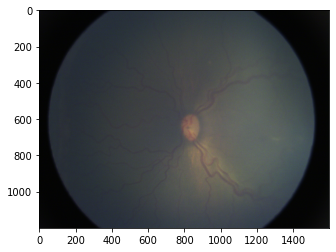

400050b4-eaac-4950-969f-e86ed150a29d.32.png
GA:         normal
normal      ['GA']
pre-plus    []
plus        ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.60 0.97
------------------------------


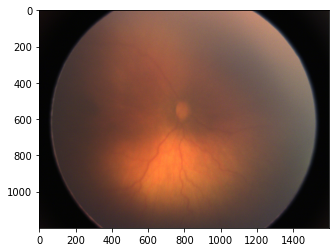

88c96afe-1004-40db-8aa1-dc20765790a0.15.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: pre-plus                                                                                              
calibrated: 0.28 0.53 0.19
------------------------------


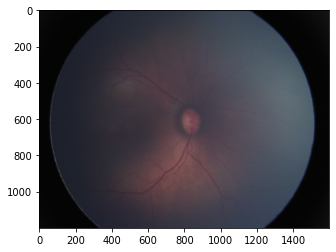

bc854dfc-559b-4c64-86ba-550d5f240178.12.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: normal                                                                                                
calibrated: 1.00 0.40 0.00
------------------------------


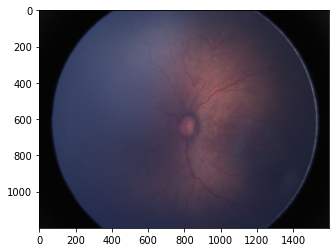

74534be2-4ce1-4b24-91e6-571acbac88df.29.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'MA']
plus        ['JR', 'HP', 'KP', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.48 0.96
------------------------------


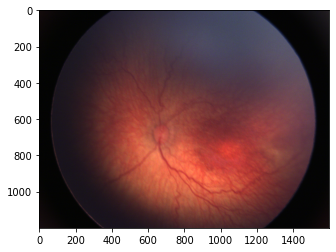

03221277-d979-473c-9bb7-90a2cdf363c4.38.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'MA']
plus        ['CH', 'JT', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.55 0.90
------------------------------


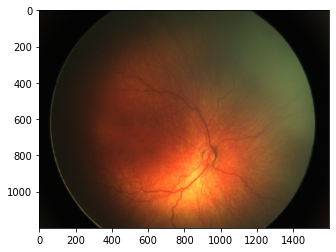

145d7193-69fd-4519-95b9-6f1eac00d693.3.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.83
------------------------------


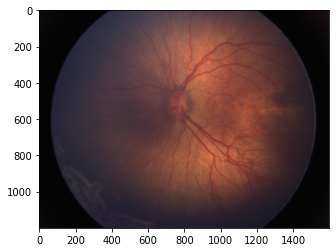

47d77c7e-6b1e-44f2-8b43-ac6ad09a1c7e.21.png
GA:         normal
normal      ['GA']
pre-plus    ['HP']
plus        ['AMH', 'CH', 'JR', 'JT', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.92
------------------------------


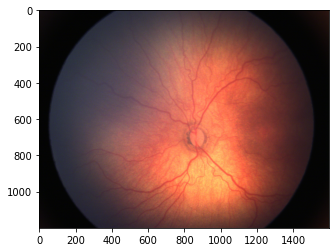

225ef7e2-8600-4da1-847f-2a5be0659bf6.12.png
GA:         pre-plus
normal      []
pre-plus    ['GA']
plus        ['AMH', 'CH', 'JR', 'JT', 'HP', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 1.00
------------------------------


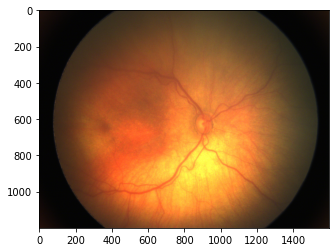

fe2fe604-cc5b-4477-bb7b-beb84f8d2cb0.1.png
GA:         plus
normal      []
pre-plus    ['AMH', 'CH', 'JR', 'JT', 'HP', 'MA', 'RH']
plus        ['GA']
calibrated: pre-plus                                                                                              
calibrated: 0.01 0.55 0.33
------------------------------


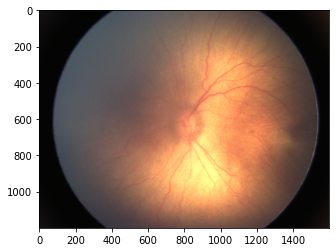

703d7099-90de-460c-87ba-3fc6e7953606.23.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'SB']
plus        ['RH']
calibrated: pre-plus                                                                                              
calibrated: 0.00 0.50 0.41
------------------------------


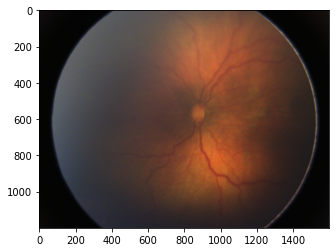

88c96afe-1004-40db-8aa1-dc20765790a0.26.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'HP']
plus        ['JR', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.52 0.69
------------------------------


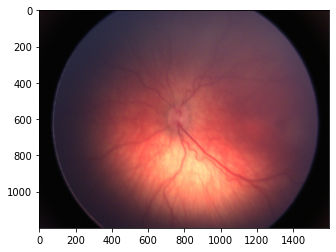

f7d27f0e-0047-4d40-9126-f2d26914fea5.36.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'CH', 'JR', 'JT', 'HP', 'RH']
plus        ['MA']
calibrated: plus                                                                                                  
calibrated: 0.00 0.55 0.78
------------------------------


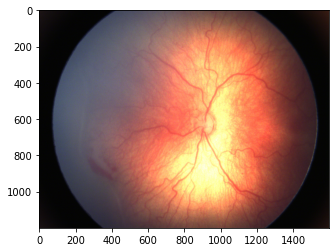

05d01d0d-5d9d-4f73-98ef-f4f9b37418aa.31.png
GA:         normal
normal      ['GA']
pre-plus    []
plus        ['AMH', 'CH', 'JR', 'JT', 'HP', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.46 1.00
------------------------------


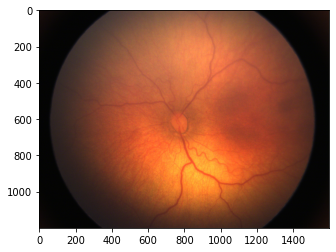

91f8a621-37ee-4518-803b-16df1a6d4f04.21.png
GA:         normal
normal      ['GA']
pre-plus    ['AMH', 'JR', 'HP', 'KP', 'MA', 'SB']
plus        ['RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.60
------------------------------


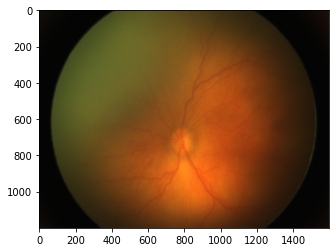

ac0699a1-ce4a-41f8-bdea-172e496cb803.30.png
GA:         plus
normal      []
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'RH']
plus        ['CH', 'GA', 'JT']
calibrated: pre-plus                                                                                              
calibrated: 0.33 0.50 0.18
------------------------------


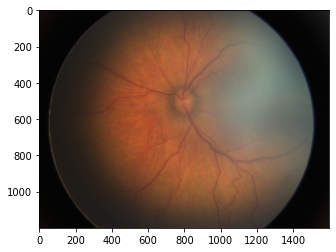

90efcf4e-0246-43cc-ad12-f76faa51f492.28.png
GA:         normal
normal      ['GA']
pre-plus    ['CH', 'JR', 'JT', 'HP']
plus        ['AMH', 'MA', 'RH']
calibrated: pre-plus                                                                                              
calibrated: 0.00 0.55 0.45
------------------------------


In [47]:
from PIL import Image
for fn in ga_different_files:
    img = Image.open('/media/QNAP/People/GongyuZhang/ROP/data/raw/image/{}'.format(fn))
    plt.imshow(img)
    plt.show()
    
    print(fn)   
    print('GA:        ', all_gradings['GA', fn])
    
    for class_name in class_names:
        print('{:10s} '.format(class_name), [grader for grader in all_graders if all_gradings[grader, fn] == class_name])
    
    print('calibrated: {:102}'.format(all_gradings['calibrated', fn]))
    print('calibrated: {:.2f} {:.2f} {:.2f}'.format(*calibrated_scores[fn]))
    print('-'*30)

## Check ambiguous files

In [48]:
unequivocal_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) == 1]
ambiguous_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) > 1]
len(unequivocal_filenames), len(ambiguous_filenames)

(114, 86)

In [49]:
for fn in ambiguous_filenames:
    print(fn)   
    print('GA:        ', all_gradings['GA', fn])
    
    for class_name in ('normal', 'pre-plus', 'plus'):
        print('{:10s} '.format(class_name), [grader for grader in all_graders if all_gradings[grader, fn] == class_name])
    
    print('calibrated: {:102}'.format(all_gradings['calibrated', fn]))
    print('calibrated: {:.2f} {:.2f} {:.2f}'.format(*calibrated_scores[fn]))
    print()

9f421e90-c634-4fc6-8eca-909a825f5908.10.png
GA:         plus
normal      []
pre-plus    ['AMH', 'JR', 'HP', 'MA', 'SB']
plus        ['GA', 'KP', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.43 1.00

bb0d6a65-0afa-4fab-a872-48cc1398f6d8.44.png
GA:         plus
normal      []
pre-plus    ['AMH', 'JR', 'HP', 'MA']
plus        ['GA', 'KP', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.90

d0d55d12-e439-4c4e-bffe-f4ba22a1268a.47.png
GA:         normal
normal      ['CH', 'GA', 'JR', 'JT', 'HP']
pre-plus    ['AMH', 'MA', 'RH']
plus        []
calibrated: pre-plus                                                                                              
calibrated: 0.03 0.60 0.29

4c774f0e-7e4c-4d73-86cf-29893fffa4c4.11.png
GA:         pre-plus
normal      []
pre-plus    ['AMH', 'GA', 'JR', 'JT'

## Confusion matrix

In [50]:
def valid(obs, fn):
    return all_gradings[obs, fn] in class_names

def get_matrix(class_name, filenames):
    

    keys = all_graders + ('calibrated',)

    n = len(keys)
    matrix = np.zeros((n, n))

    for y, obs_y in enumerate(keys):
        for x, obs_x in enumerate(keys):
            include_filenames = [fn for fn in filenames if valid(obs_y, fn) and valid(obs_x, fn)]
            y_bin = np.array([all_gradings[obs_y, fn] == class_name for fn in include_filenames])
            x_bin = np.array([all_gradings[obs_x, fn] == class_name for fn in include_filenames])

            agreement = np.sum(y_bin==x_bin) / len(include_filenames)
            matrix[y, x] = agreement
            #print('{:0.2f}'.format(agreement), end = ' ')
        #print()
    return matrix
        
def plot_confusion(matrix):
    n = len(all_graders)
    fig = plt.figure(figsize=(15, 15))
    plt.clf()
    ax = fig.add_subplot(111)
    r = ax.imshow(matrix, clim=[0,1])
    for x in range(n):
        for y in range(n):
            ax.annotate('{:0.2f}'.format(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.set_xticks(range(0, n))
    ax.xaxis.tick_top()
    ax.set_yticks(range(n-1, -1, -1))
    ax.set_xticklabels(all_graders)
    ax.set_yticklabels(all_graders[::-1])
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    cb = fig.colorbar(r)


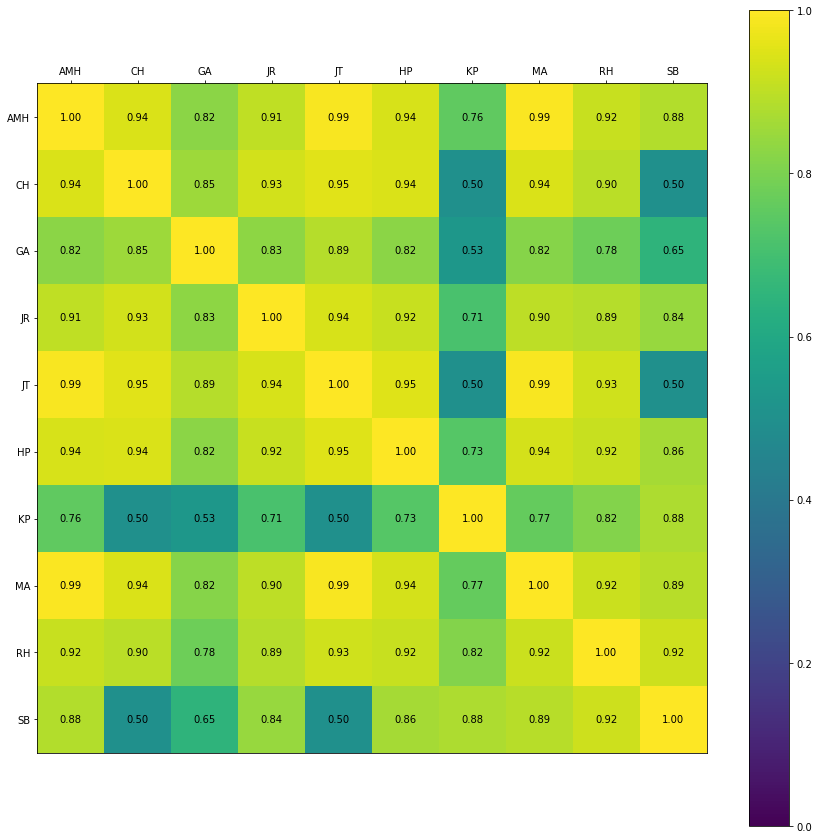

In [51]:
plot_confusion(get_matrix('normal', test_filenames))

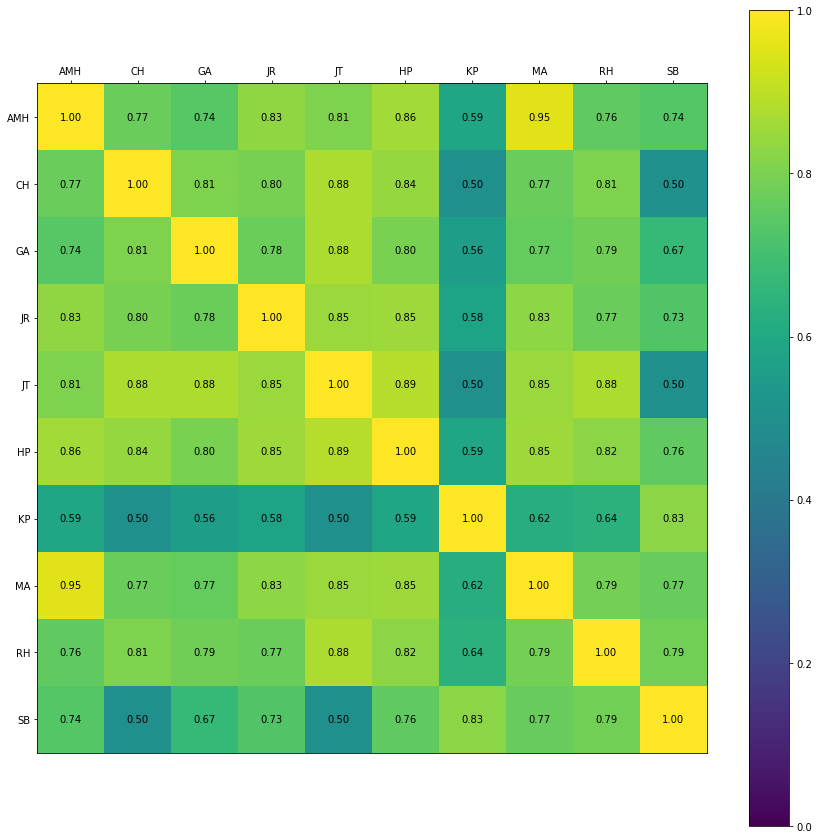

In [52]:
plot_confusion(get_matrix('pre-plus', test_filenames))

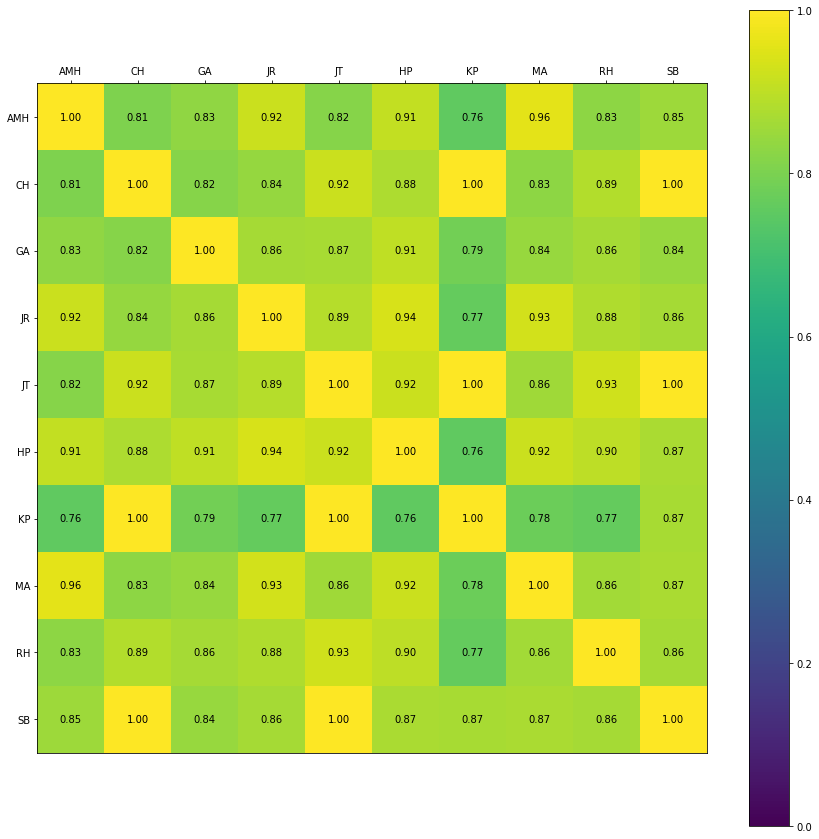

In [53]:
plot_confusion(get_matrix('plus', test_filenames))